# Overview

This notebook demonstrates terrain generation, ray tracing, and analytic optic flow for a planar drone. The optic flow represents the angular velocity of visual features as perceived by a camera-equipped drone flying over terrain. We will use this higher dimensional representation of optic flow information to demonstrate dimensionality reduction tools.

**Topics covered:**

1. **Install and Import Packages**
2. **Terrain Generation and Ray Tracing**
3. **Analytic Optic Flow Math**
4. **Optic Flow Demonstrations**
5. **Exercises**
6. **Next Steps**

**Key learning objectives:**
- Understand the full equations for optic flow
- Gain intuition for optic flow patterns corresponding to different types of motion
- Consider the implications on estimators that high dimensional optic flow measurements will have

# 1.&nbsp;Install and Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

  Preparing metadata (setup.py) ... done
✓ nonlinear_estimation_utilities installed
✓ You have the latest version (0.0.32)


## Install requirements

In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()

Attempting to pip install: casadi
Attempting to pip install: do_mpc
Attempting to pip install: git+https://github.com/vanbreugel-lab/pybounds
Attempting to pip install: pynumdiff


## Load planar drone modules

We will use some helper functions from the module `terrain_and_optic_flow_utility` to generate terrain, perform ray tracing, and calculate analytic optic flow. We will not go into the details of those functions, but you can explore them on your own.

In [4]:
nonlinear_estimation_utilities.load_planar_drone_modules()

## Import modules

In [5]:
import copy
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import pynumdiff

In [7]:
from nonlinear_estimation_utilities import planar_drone
from nonlinear_estimation_utilities import generate_training_data_utility
from nonlinear_estimation_utilities import terrain_and_optic_flow_utility

# 2.&nbsp;Terrain Generation and Ray Tracing

We use procedural terrain generation to create realistic elevation profiles. The terrain is represented as a 2D height map, and we use ray tracing to determine which terrain features are visible from the drone's camera at different positions and orientations.

## Generate terrain

In [8]:
terrain = terrain_and_optic_flow_utility.Terrain(seed=0)

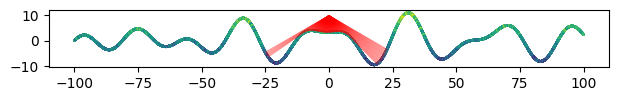

In [9]:
img = terrain_and_optic_flow_utility.get_image(terrain, [0, 10], plot=True)

# 3.&nbsp;Analytic Optic Flow

Optic flow describes how visual features move across the image plane as the observer moves through the environment. For a planar drone, we can derive analytic expressions for optic flow based on the drone's velocity and position relative to terrain features.

## Optic flow equation

Consider the following trigonometric relationship for an agent moving in the plane (from [Lingenfelter, Nag, & van Breugel](https://iopscience.iop.org/article/10.1088/1748-3190/ac1f7b/meta)):

<img src="https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation/blob/main/images/optic_flow_lingenfelter.png?raw=1" alt="Optic flow geometry" width="600"/>


For each ray we can write the following trigonometric relationship where $l$ and $d$ correspond to the lateral and frontal distance to a terrain feature:

$$
\tan(\alpha) = l/d.
$$

Taking the derivative with respect to time we find the following relationship for optic flow (angular image velocity):

$$
\dot{\alpha} = \bigg( \frac{ \frac{\delta}{\delta t} l }{d} - \frac{ l \frac{\delta}{\delta t} d }{d^2} \bigg) \cos^2(\alpha)
$$

Placing this in the context of our planar drone variables we have:

$$
\dot{\alpha} = \bigg( \frac{ \dot{x} }{z} - \frac{ z \tan(\alpha) \dot{z} }{z^2} \bigg) \cos^2(\alpha)
$$

This equation shows that optic flow depends on both horizontal velocity ($\dot{x}$) and vertical velocity ($\dot{z}$), as well as the drone's altitude ($z$) and the viewing angle ($\alpha$).

# 4.&nbsp;Optic Flow Demonstrations

We'll explore how different motion patterns produce different optic flow signatures. This helps build intuition for how optic flow can be used for state estimation.

## Setup trajectory and simulation parameters

First, we'll generate a reference trajectory (the "squiggle") that we'll modify for different demonstrations.

In [10]:
terrain = terrain_and_optic_flow_utility.Terrain(x_min=-100, x_max=100, seed=0)

In [11]:
f = planar_drone.F(k=1).f
h = planar_drone.H('h_camera_imu', k=1).h

dt=0.1

t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, dt=dt,
                                                                    tsim_length=10, trajectory_shape='bigsquiggle', rterm=1e-3)

In [12]:
trajec_squiggle = planar_drone.package_data_as_pandas_dataframe(t_sim, x_sim, u_sim, y_sim)

## Optic flow for horizontal motion only

When the drone moves only in the horizontal direction ($\dot{x} \neq 0$, $\dot{z} = 0$), optic flow varies across the field of view. Features directly ahead or behind show minimal flow, while features to the side show maximum flow.

In [13]:
# build a trajectory that is just moving in x
trajec_constz = copy.copy(trajec_squiggle)
trajec_constz.z *= 0
trajec_constz.z += 5
_, trajec_constz.z_dot = pynumdiff.finite_difference.first_order(trajec_constz.z, dt)

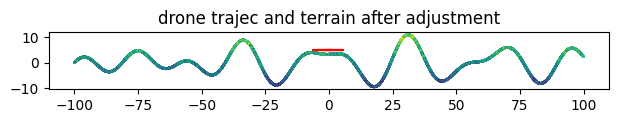

In [14]:
# plot trajec and terrain to verify
trajec_constz_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(trajec_constz, terrain, plot=True)

In [15]:
# find optic flow and ray distances for the whole trajectory
imgs, optic_flows, ray_distances = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(trajec_constz_adj, terrain)

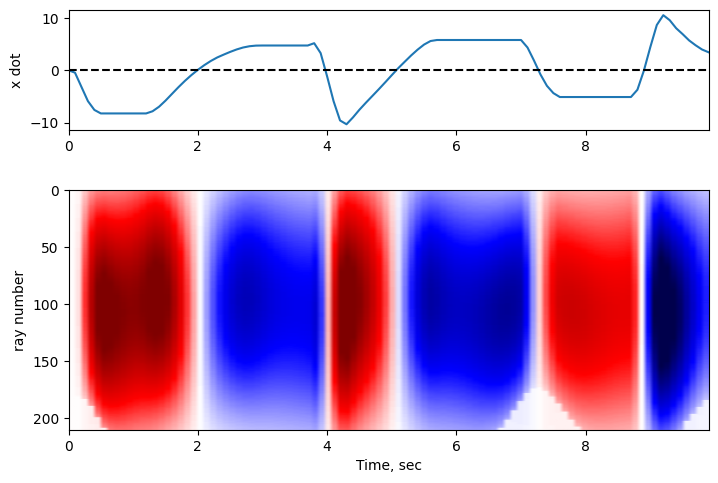

In [16]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0.2, 0.7, 0.8, 0.2])
ax2 = fig.add_axes([0.2, 0.2, 0.8, 0.4])

ax1.plot(trajec_constz_adj.time.values, trajec_constz_adj.x_dot.values)
ax1.set_xlim([trajec_constz_adj.time.values.min(), trajec_constz_adj.time.values.max()])
ax1.hlines(0, trajec_constz_adj.time.values.min(), trajec_constz_adj.time.values.max(),
           linestyles='--', colors='black')
ax1.set_ylabel('x dot')

ax2.imshow(optic_flows, vmin=-5, vmax=5, cmap='seismic', extent=[trajec_constz_adj.time.values.min(),
                                                                 trajec_constz_adj.time.values.max(),
                                                                 210, 0])
ax2.set_ylabel('ray number')
ax2.set_xlabel('Time, sec')

ax2.set_aspect('auto')

## Optic flow for vertical motion only

When the drone moves only in the vertical direction ($\dot{x} = 0$, $\dot{z} \neq 0$), the optic flow pattern is radial - all features appear to move outward (descending) or inward (ascending) from a focus of expansion.

In [17]:
# build a trajectory that is just moving in x
trajec_constx = copy.copy(trajec_squiggle)
trajec_constx.x *= 0
_, trajec_constx.x_dot = pynumdiff.finite_difference.first_order(trajec_constx.x, dt)

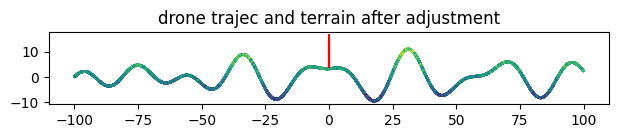

In [18]:
# plot trajec and terrain to verify
trajec_constx_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(trajec_constx, terrain, plot=True)

In [19]:
# find optic flow and ray distances for the whole trajectory
imgs, optic_flows, ray_distances = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(trajec_constx_adj, terrain)

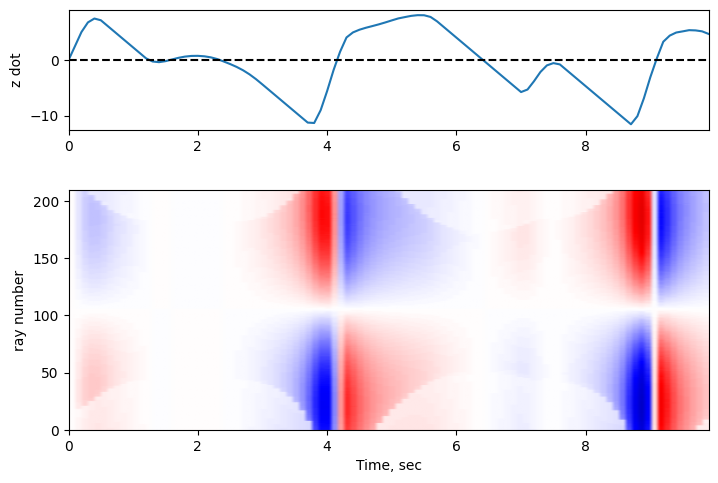

In [20]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0.2, 0.7, 0.8, 0.2])
ax2 = fig.add_axes([0.2, 0.2, 0.8, 0.4])

ax1.plot(trajec_constx_adj.time.values, trajec_constx_adj.z_dot.values)
ax1.set_xlim([trajec_constx_adj.time.values.min(), trajec_constx_adj.time.values.max()])
ax1.hlines(0, trajec_constx_adj.time.values.min(), trajec_constx_adj.time.values.max(),
           linestyles='--', colors='black')
ax1.set_ylabel('z dot')

ax2.imshow(optic_flows, vmin=-5, vmax=5, cmap='seismic', extent=[trajec_constz_adj.time.values.min(),
                                                                 trajec_constz_adj.time.values.max(),
                                                                 0, 210])
ax2.set_ylabel('ray number')
ax2.set_xlabel('Time, sec')

ax2.set_aspect('auto')

## Optic flow for combined horizontal and vertical motion

Real drone trajectories involve both horizontal and vertical motion. The resulting optic flow patterns are combinations of the horizontal and vertical components, creating complex but informative visual signatures.

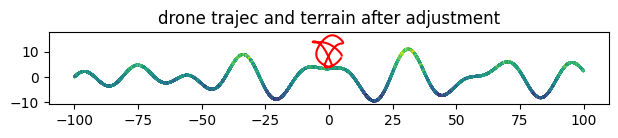

In [21]:
# plot trajec and terrain to verify
trajec_adj = terrain_and_optic_flow_utility.adjust_trajec_altitude(trajec_squiggle, terrain, plot=True)

In [22]:
# find optic flow and ray distances for the whole trajectory
imgs, optic_flows, ray_distances = terrain_and_optic_flow_utility.get_imgs_and_analytic_optic_flows(trajec_adj, terrain)

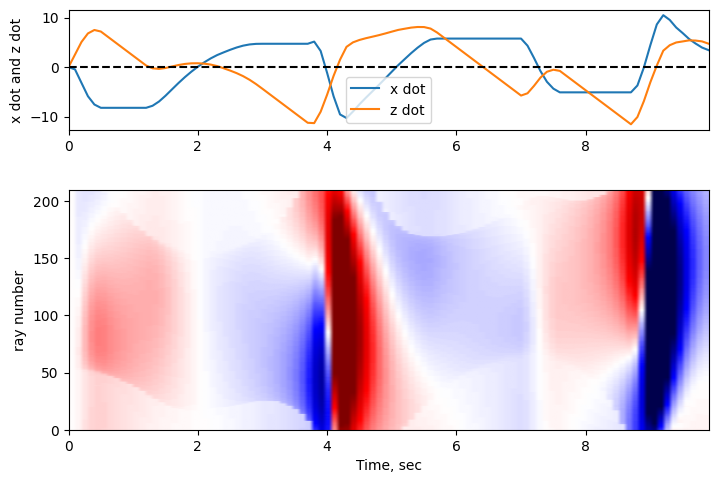

In [23]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_axes([0.2, 0.7, 0.8, 0.2])
ax2 = fig.add_axes([0.2, 0.2, 0.8, 0.4])

ax1.plot(trajec_adj.time.values, trajec_adj.x_dot.values, label='x dot')
ax1.plot(trajec_adj.time.values, trajec_adj.z_dot.values, label='z dot')
ax1.legend()
ax1.set_xlim([trajec_adj.time.values.min(), trajec_adj.time.values.max()])
ax1.hlines(0, trajec_adj.time.values.min(), trajec_adj.time.values.max(),
           linestyles='--', colors='black')
ax1.set_ylabel('x dot and z dot')

ax2.imshow(optic_flows, vmin=-5, vmax=5, cmap='seismic', extent=[trajec_adj.time.values.min(),
                                                                 trajec_adj.time.values.max(),
                                                                 0, 210])
ax2.set_ylabel('ray number')
ax2.set_xlabel('Time, sec')

ax2.set_aspect('auto')

# 5.&nbsp;Exercises

1. Change the location of the big squiggle trajectory so that it happens over a more complicated piece of the terrain -- i.e. a region with large changes in elevation.
    * Question: How does terrain complexity affect the optic flow patterns?

2. In our previous notebooks we simplified optic flow to $\dot{x}/z$. The new equations include a dependence on $\dot{z}$.
    * Question: Under what circumstances will this new term in the optic flow equation improve, or make more challenging, estimation of altitude?

3. How many individual optic flow measurements do we have now (consider each ray as a separate measurement)?
    * Question: How do you think this will affect any attempts to build a ANN estimator using these optic flow measurements?



# 6.&nbsp;Next Steps

## Generating training datasets

Running the main script of `../Utility/terrain_and_optic_flow_utility` will generate 3,000 trajectories with random terrain and calculate the corresponding analytic optic flow and ray distances. These datasets can be used to:

- Train neural network estimators
- Validate filter performance
- Study the information content of optic flow for different motion profiles

A subset of these trajectories can be downloaded from this github repo. The complete dataset is stored elsewhere due to size constraints.